In [ ]:
"""
考虑一个食物网, 有以下生物
生产者:水稻, 稗草
初级消费者:鼠(吃水稻和稗草), 蝗虫(吃水稻和稗草)
次级消费者:蝙蝠(吃蝗虫), 蛇(吃鼠和蝗虫), 蜘蛛(吃蝗虫)
顶级消费者:鹰(吃蛇,蜘蛛和鼠)
细菌(分解者, 由其他生物死亡率与种群大小加权作为养料, 植物消耗它)

最开始的时候, 一部分森林会因为开垦变成农田(表现出来是树和稗草的数量大大减小, 水稻大大增加), 时间间隔T后
农田会被收割, 再过T, 重新播种(不会再次清除树和稗草), 重复播种收割的过程5次,
用Rosenzweig-MacArthur模型构建食物网, 模拟这个过程, 并把每一个T间隔的过程和整体的过程画图, 用scipy
"""

In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import exp

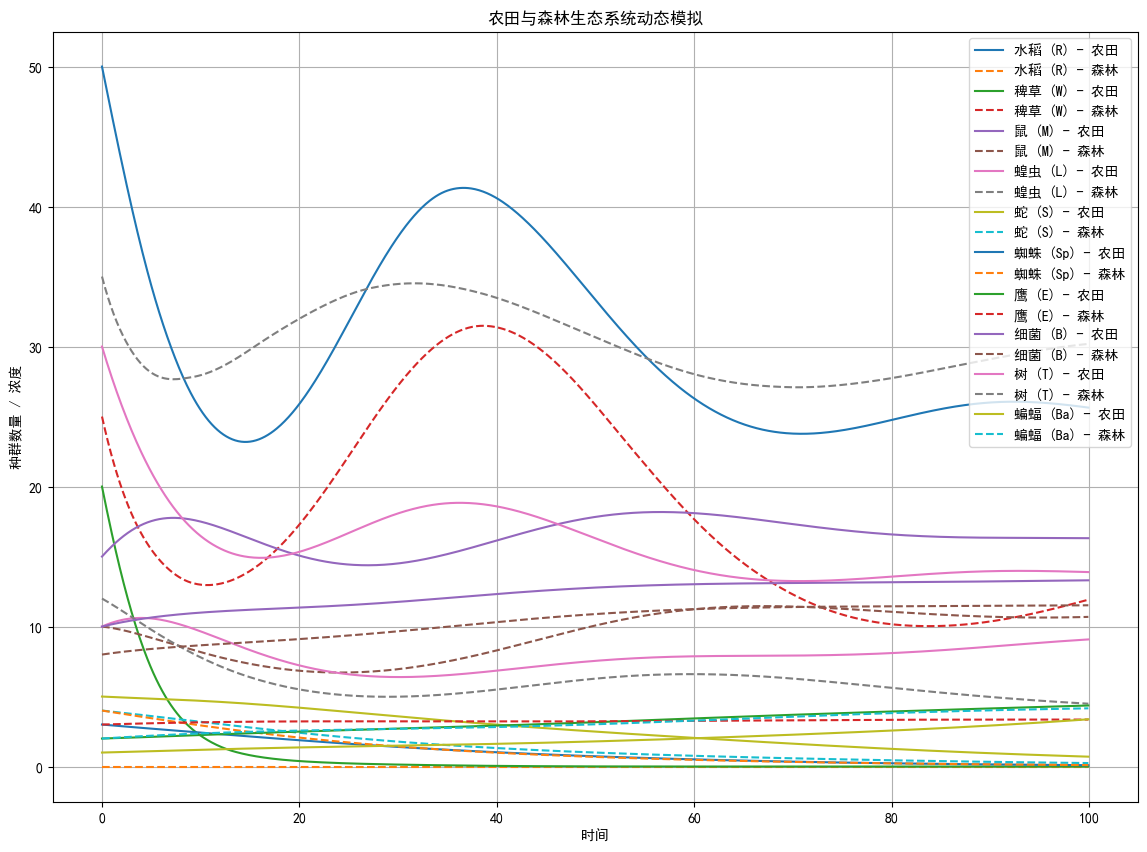

In [50]:
class Biome:
    def __init__(self, name, params, initial_values, species_indices):
        """
        Initialize the Biome with its name, parameters, initial species values, and species indices.

        Args:
            name (str): Name of the biome (e.g., 'Farm', 'Forest').
            params (tuple): Parameters for the differential equations.
            initial_values (list): Initial population values for each species.
            species_indices (dict): Mapping of species names to their indices in the state vector.
        """
        self.name = name
        self.params = params
        self.initial_values = initial_values
        self.species_indices = species_indices
        self.another = None  # Reference to the other biome for migration

        # Define migration rates for each species
        # Plants have lower migration rates; animals have higher rates
        self.migration_rates = {
            'R': 0,   # 水稻 (Rice)
            'W': 0.0001,   # 稗草 (Barnyard Grass)
            'M': 0.01,    # 鼠 (Mouse)
            'L': 0.01,    # 蝗虫 (Locust)
            'S': 0.005,   # 蛇 (Snake)
            'Sp': 0.005,  # 蜘蛛 (Spider)
            'E': 0.002,   # 鹰 (Eagle)
            'B': 0.001,   # 细菌 (Bacteria)
            'T': 0.001,   # 树 (Tree)
            'Ba': 0.003   # 蝙蝠 (Bat)
        }
        self.current_dir=np.zeros((len(self.species_indices)))
    def set_another(self, other_biome):
        """
        Set the reference to the other biome for migration purposes.

        Args:
            other_biome (Biome): The other biome instance.
        """
        self.another = other_biome

    def fret_func(self, x, t):
        """
        Fertilizer effect function.

        Args:
            x (float): Current fertilizer parameter.
            t (float): Current time.

        Returns:
            float: Modified fertilizer parameter based on time and current value.
        """
        if x <= 0.5:
            return (1 + 1.6 * x**2) * np.exp(-t / 200)
        else:
            return 1.4 * np.exp(-10 * (x - 0.5)) * np.exp(-t / 200)

    def migration_terms(self, y, dy):
        """
        Calculate migration in and out of the biome for each species.

        Args:
            y (list): Current population values of species.

        Returns:
            list: Migration terms for each species.
        """
        sigmoid=lambda x:1/(1+exp(-x))
        migration = np.zeros(len(self.initial_values))
        if self.another:
            for species, rate in self.migration_rates.items():
                idx = self.species_indices[species]
                migration_out = rate * y[idx]
                migration_out*=-sigmoid(dy[idx])+0.5
                migration_in = rate * self.another.initial_values[idx]
                migration_in*=-sigmoid(self.another.current_dir[idx])+0.5
                migration[idx] += migration_in - migration_out
        return migration

    def gen(self, t, y):
        """
        Generate the derivatives for the differential equations, including migration.

        Args:
            t (float): Current time.
            y (list): Current population values of species.

        Returns:
            list: Derivatives of species populations.
        """
        # Unpack parameters
        (
            rR, KR, rW, KW,
            aRM, bRM, eMR, aWM, bWM, eMW,
            aRL, bRL, eLR, aWL, bWL, eLW,
            aSM, bSM, eSM, aSL, bSL, eSL,
            aSpL, bSpL, eSpL,
            aES, bES, eES, aESp, bESp, eESp, aEM, bEM, eEM,
            aBR, bBR, eRB, aBW, bBW, eWB,
            alphaB, dR, dW, dM, dL, dS, dSp, dE, dB,
            rT, KT, aTM, bTM, eTM, aTL, bTL, eTL, dT,
            aBaL, bBaL, eBaL, dBa,
            fret  # Fertilizer parameter
        ) = self.params

        # Species indices
        R = y[self.species_indices['R']]
        W = y[self.species_indices['W']]
        M = y[self.species_indices['M']]
        L = y[self.species_indices['L']]
        S = y[self.species_indices['S']]
        Sp = y[self.species_indices['Sp']]
        E = y[self.species_indices['E']]
        B_ = y[self.species_indices['B']]
        T_ = y[self.species_indices['T']]
        Ba = y[self.species_indices['Ba']]

        # ----- Compute Consumption Rates -----
        # 1) Water Rice (R) Consumption
        cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
        cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
        cons_B_by_R = (aBR * B_ * R) / (1.0 + bBR * B_)
        gain_R_from_B = eRB * cons_B_by_R

        # 2) Barnyard Grass (W) Consumption
        cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
        cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
        cons_B_by_W = (aBW * B_ * W) / (1.0 + bBW * B_)
        gain_W_from_B = eWB * cons_B_by_W

        # 3) Tree (T) Consumption
        cons_T_by_M = (aTM * T_ * M) / (1.0 + bTM * T_)
        cons_T_by_L = (aTL * T_ * L) / (1.0 + bTL * T_)
        gain_M_from_T = eTM * cons_T_by_M
        gain_L_from_T = eTL * cons_T_by_L

        # 4) Mouse (M) Consumption
        gain_M_from_R = eMR * cons_R_by_M
        gain_M_from_W = eMW * cons_W_by_M
        cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
        cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)

        # 5) Locust (L) Consumption
        gain_L_from_R = eLR * cons_R_by_L
        gain_L_from_W = eLW * cons_W_by_L
        cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
        cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)
        cons_L_by_Ba = (aBaL * L * Ba) / (1.0 + bBaL * L)

        # 6) Snake (S) Consumption
        gain_S_from_M = eSM * cons_M_by_S
        gain_S_from_L = eSL * cons_L_by_S
        cons_S_by_E = (aES * S * E) / (1.0 + bES * S)

        # 7) Spider (Sp) Consumption
        gain_Sp_from_L = eSpL * cons_L_by_Sp
        cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)

        # 8) Eagle (E) Consumption
        gain_E_from_S = eES * cons_S_by_E
        gain_E_from_Sp = eESp * cons_Sp_by_E
        gain_E_from_M = eEM * cons_M_by_E

        # 9) Bacteria (B)
        total_death_flux = (
            dR * R + dW * W + dM * M +
            dL * L + dS * S + dSp * Sp +
            dE * E + dT * T_
        )
        bacteria_growth = alphaB * total_death_flux

        # 10) Bat (Ba) Consumption
        gain_Ba_from_L = eBaL * cons_L_by_Ba

        # ----- Compute Derivatives -----
        # Applying fertilizer effect on R, W, T
        modified_rR = rR + 0.01 * Ba * self.fret_func(fret, t)
        modified_rW = rW + 0.01 * Ba * self.fret_func(fret, t)
        modified_rT = rT + 0.01 * Ba * self.fret_func(fret, t)

        dRdt = modified_rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R
        dWdt = modified_rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W
        dTdt = modified_rT * T_ * (1 - T_ / KT) - cons_T_by_M - cons_T_by_L - dT * T_

        dMdt = gain_M_from_R + gain_M_from_W + gain_M_from_T - cons_M_by_S - cons_M_by_E - dM * M
        dLdt = (gain_L_from_R + gain_L_from_W + gain_L_from_T
                - cons_L_by_S - cons_L_by_Sp
                - cons_L_by_Ba - dL * L)
        dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S
        dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp
        dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E
        dBdt = bacteria_growth - dB * B_
        dBadt = gain_Ba_from_L - dBa * Ba

        # ----- Apply Migration Terms -----
        dy=(dR, dW, dM, dL, dS, dSp, dE, dB, dT, dBa)
        migration = self.migration_terms(y, dy)

        # Combine all derivatives
        derivatives = [
            dRdt + migration[self.species_indices['R']],
            dWdt + migration[self.species_indices['W']],
            dMdt + migration[self.species_indices['M']],
            dLdt + migration[self.species_indices['L']],
            dSdt + migration[self.species_indices['S']],
            dSpdt + migration[self.species_indices['Sp']],
            dEdt + migration[self.species_indices['E']],
            dBdt + migration[self.species_indices['B']],
            dTdt + migration[self.species_indices['T']],
            dBadt + migration[self.species_indices['Ba']]
        ]
        self.current_dir=np.array(dy)
        return derivatives

def my_plot(sol_farm, sol_forest, species_labels):
    """
    Plot the population dynamics of species in both Farm and Forest biomes.

    Args:
        sol_farm (OdeResult): Simulation results for the Farm biome.
        sol_forest (OdeResult): Simulation results for the Forest biome.
        species_labels (list): List of species names for labeling.
    """
    plt.rcParams['font.family'] = 'SimHei'  # For displaying Chinese characters if needed
    plt.figure(figsize=(14, 10))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('农田与森林生态系统动态模拟')

    for i, label in enumerate(species_labels):
        plt.plot(sol_farm.t, sol_farm.y[i], label=f'{label} - 农田')
        plt.plot(sol_forest.t, sol_forest.y[i], linestyle='--', label=f'{label} - 森林')

    plt.legend()
    plt.grid(True)
    plt.show()

# Define species indices for clarity
species_indices = {
    'R': 0,    # 水稻 (Rice)
    'W': 1,    # 稗草 (Barnyard Grass)
    'M': 2,    # 鼠 (Mouse)
    'L': 3,    # 蝗虫 (Locust)
    'S': 4,    # 蛇 (Snake)
    'Sp': 5,   # 蜘蛛 (Spider)
    'E': 6,    # 鹰 (Eagle)
    'B': 7,    # 细菌 (Bacteria)
    'T': 8,    # 树 (Tree)
    'Ba': 9    # 蝙蝠 (Bat)
}

# Sample parameters (These values are illustrative; adjust as needed)
sample_params = (
    0.5, 100, 0.3, 80,      # rR, KR, rW, KW
    0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aRM, bRM, eMR, aWM, bWM, eMW
    0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aRL, bRL, eLR, aWL, bWL, eLW
    0.01, 0.01, 0.1, 0.01, 0.01, 0.1, # aSM, bSM, eSM, aSL, bSL, eSL
    0.01, 0.01, 0.1,                 # aSpL, bSpL, eSpL
    0.01, 0.01, 0.1, 0.01, 0.01, 0.1, # aES, bES, eES, aESp, bESp, eESp
    0.01, 0.01, 0.1,                 # aEM, bEM, eEM
    0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aBR, bBR, eRB, aBW, bBW, eWB
    0.2,                             # alphaB
    0.01, 0.01, 0.01, 0.01, 0.01,   # dR, dW, dM, dL, dS
    0.01, 0.01, 0.01,                # dSp, dE, dB
    0.3, 50, 0.01, 0.01, 0.1,        # rT, KT, aTM, bTM, eTM
    0.01, 0.01, 0.1, 0.01,           # aTL, bTL, eTL, dT
    0.01, 0.01, 0.3, 0.01,           # aBaL, bBaL, eBaL, dBa
    0.0                              # fret (Fertilizer parameter)
)

# Initial population values for Farm Biome
sample_initial_vals_farm = [
    50.0,  # R: 水稻 (Rice)
    20.0,  # W: 稗草 (Barnyard Grass)
    15.0,  # M: 鼠 (Mouse)
    10.0,  # L: 蝗虫 (Locust)
    5.0,   # S: 蛇 (Snake)
    3.0,   # Sp: 蜘蛛 (Spider)
    2.0,   # E: 鹰 (Eagle)
    10.0,  # B: 细菌 (Bacteria)
    30.0,  # T: 树 (Tree)
    1.0    # Ba: 蝙蝠 (Bat)
]

# Initial population values for Forest Biome
sample_initial_vals_forest = [
    0.0,  # R: 水稻 (Rice)
    25.0,  # W: 稗草 (Barnyard Grass)
    10.0,  # M: 鼠 (Mouse)
    12.0,  # L: 蝗虫 (Locust)
    4.0,   # S: 蛇 (Snake)
    4.0,   # Sp: 蜘蛛 (Spider)
    3.0,   # E: 鹰 (Eagle)
    8.0,   # B: 细菌 (Bacteria)
    35.0,  # T: 树 (Tree)
    2.0    # Ba: 蝙蝠 (Bat)
]

# Instantiate Biome objects
farm_biome = Biome('农田', sample_params, sample_initial_vals_farm, species_indices)
forest_biome = Biome('森林', sample_params, sample_initial_vals_forest, species_indices)

# Set mutual references for migration
farm_biome.set_another(forest_biome)
forest_biome.set_another(farm_biome)

# Simulation parameters
t_end = 100      # Total time units
points = 0.1     # Time interval for evaluation

# Run the simulation for Farm Biome
sol_farm = solve_ivp(
    fun=farm_biome.gen,
    t_span=(0, t_end),
    y0=farm_biome.initial_values,
    method='RK45',
    t_eval=np.arange(0, t_end, points)
)

# Run the simulation for Forest Biome
sol_forest = solve_ivp(
    fun=forest_biome.gen,
    t_span=(0, t_end),
    y0=forest_biome.initial_values,
    method='RK45',
    t_eval=np.arange(0, t_end, points)
)

# Species labels for plotting
species_labels = [
    '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
    '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
]

# Plot the results
my_plot(sol_farm, sol_forest, species_labels)

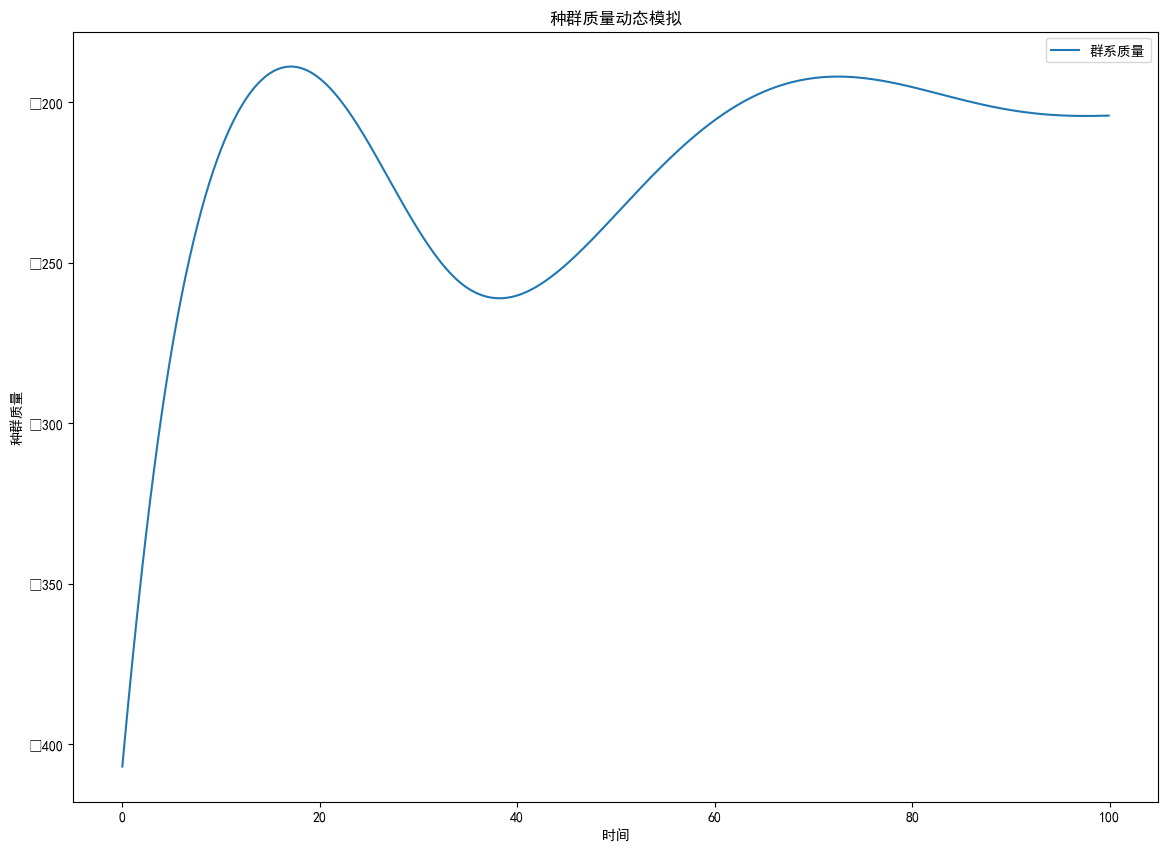

In [49]:
from math import log
def get_quality(q_sol):
    qu_sat=[]
    price=1
    for idx in range(q_sol.y.shape[1]):
        qu_sat.append(sum([-i*log(i) for i in q_sol.y[:,idx]])+price*q_sol.y[0,idx])

    return qu_sat
qu=get_quality(sol_farm)
tt=[i/10 for i in range(len(qu))]
plt.rcParams['font.family'] = 'SimHei'  # For displaying Chinese characters if needed
plt.figure(figsize=(14, 10))
plt.xlabel('时间')
plt.ylabel('种群质量')
plt.title('种群质量动态模拟')
plt.plot(tt, qu, label="群系质量")
plt.legend()
plt.show()